In [1]:
# %tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download data and unzip

In [3]:
!wget --no-check-certificate \
    https://djangocolab.blob.core.windows.net/aidatacolab2/heart_4_classes_206_52.zip\
    -O heart_4_classes_206_52.zip

--2021-06-17 03:01:23--  https://djangocolab.blob.core.windows.net/aidatacolab2/heart_4_classes_206_52.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 559006 (546K) [application/zip]
Saving to: ‘heart_4_classes_206_52.zip’

heart_4_classes_206 100%[===================>] 545.90K  2.22MB/s    in 0.2s    

2021-06-17 03:01:24 (2.22 MB/s) - ‘heart_4_classes_206_52.zip’ saved [559006/559006]



In [4]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [5]:
local_zip = 'heart_4_classes_206_52.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

!rm -r __MACOSX
# !rm heart_4_classes/test/*/.DS*
# !rm heart_4_classes/train/inferior/.DS*

In [6]:
train_root = os.path.join("heart_4_classes_206_52", "train")
test_root = os.path.join("heart_4_classes_206_52", "test")

train_folders = [i for i in os.listdir(train_root) if not i.startswith('.')]
test_folders = [i for i in os.listdir(test_root) if not i.startswith('.')]

train_count = 0
test_count = 0

for f in train_folders:
  files = [i for i in os.listdir(os.path.join(train_root, f)) if not i.startswith('.')]
  print(len(files), "images in folder '", f, "'")
  train_count = train_count + len(files)
print("***", train_count, "training images")

for f in test_folders:
  files = [i for i in os.listdir(os.path.join(test_root, f)) if not i.startswith('.')]
  print(len(files), "images in folder '", f, "'")
  test_count = test_count + len(files)
print("***", test_count, "testing images")

5 images in folder ' Septal '
76 images in folder ' ApicalAnterior '
41 images in folder ' normal '
84 images in folder ' Basal '
*** 206 training images
2 images in folder ' Septal '
19 images in folder ' ApicalAnterior '
10 images in folder ' normal '
21 images in folder ' Basal '
*** 52 testing images


heart_4_classes_206_52/train/ApicalAnterior/C0873 normal.png
(512, 512)


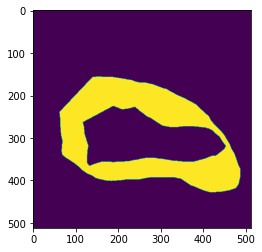

heart_4_classes_206_52/train/ApicalAnterior/C1106 (2.3).png
(512, 512)


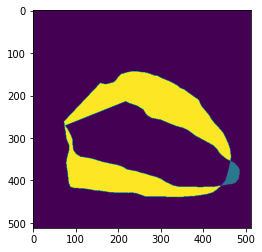

heart_4_classes_206_52/train/ApicalAnterior/2C0581 normal.png
(512, 512)


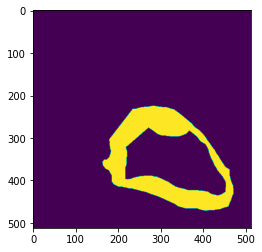

In [7]:
pic_index = 3
target_folder = "ApicalAnterior"

files = [i for i in os.listdir(os.path.join(train_root, target_folder)) if not i.startswith('.')]
next_files = [os.path.join(train_root, target_folder, f) for f in files[0:pic_index]]
for i, img_path in enumerate(next_files):
  print(img_path)
  img = mpimg.imread(img_path)
  print(img.shape)
  plt.imshow(img)
  plt.show()

## Import libraries

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

import numpy as np
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix
import itertools

## Utils

In [39]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Reds):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    #plt.ylim([4.5, -0.5]) # solve squished issue

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix!")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i , cm[i, j],
                horizontalalignment = "center",
                color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
def calculate_acc(cm):
  total = 0
  ok = 0
  row, col = cm.shape
  for i in range(row):
    for j in range(col):
      if i == j:
        total = total + cm[i,j]
        ok = ok + cm[i,j]
      else:
        total = total + cm[i,j]
  return print("accuracy:", round(ok/total,3))

def calculate_metrics(cm):
  FP = cm.sum(axis=0) - np.diag(cm) 
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)
  # Sensitivity, recall, or true positive rate
  TPR = TP/(TP+FN)
  print("Sensitivity/Recall for each class:", TPR)
  print("Sensitivity/Recall:", round(np.mean(TPR),3))
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  print("Specificity for each class:", TNR)
  print("Specificity:", round(np.mean(TNR),3))
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  print("Precision for each class:", PPV)
  print("Precision:", round(np.mean(PPV),3))

  # # Overall accuracy for each class
  # ACC = (TP+TN)/(TP+FP+FN+TN)
  # print("Accuracy for each class:", ACC)
  # print("Accuracy:", round(np.mean(ACC),3))

  # # recall(sensitivity)
  # recall = np.diag(cm) / np.sum(cm, axis = 1)
  # #precision
  # precision = np.diag(cm) / np.sum(cm, axis = 0)

https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872  
https://stats.stackexchange.com/questions/51296/how-do-you-calculate-precision-and-recall-for-multiclass-classification-using-co  

## Build the model with pretrained model

In [10]:
width = 512
height = 512

inputs = Input(shape=(width, height, 3))
inp = preprocess_input(inputs)

base_model = EfficientNetB3(include_top=False,
              weights='imagenet',
              input_shape=(width, height,3),
              input_tensor=inp)

base_model.summary()

43941888/43941136 [==============================] - 0s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
____________________

In [11]:
base_model.layers[263].name # 263 b3 323 b4

'block5e_add'

In [12]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 263 # 263 b3 323 b4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

base_model.summary()

Number of layers in the base model:  384
Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
____________________________________________

In [13]:
top_activation = base_model.get_layer('top_activation')
# inputs = Input(shape=(512,512,3))
# x = preprocess_input(inputs)
# x = base_model(x)

x = GlobalAveragePooling2D()(top_activation.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer=Adam(lr=1e-4),   # lower the learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Data augmentation

In [14]:
gobj = ImageDataGenerator(# validation_split=0.2, #use fewer training data in this transfer learning case on purpose
    # rescale=1./255, 
    rotation_range=20,     
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=10,         
    zoom_range=0.1,        
    horizontal_flip=False)  

trn_gen = gobj.flow_from_directory( 
    'heart_4_classes_206_52/train',         
    target_size=(width, height),  
    batch_size=8,        
    class_mode='sparse',    
    subset='training')      

Found 206 images belonging to 4 classes.


In [15]:
gobj = ImageDataGenerator() # rescale=1./255

val_gen = gobj.flow_from_directory( 
    'heart_4_classes_206_52/test',          
    target_size=(width, height),
    batch_size=2,
    class_mode='sparse')

Found 52 images belonging to 4 classes.


In [16]:
# make sure two dictionaries are the same
labels = (trn_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
labels = (val_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'ApicalAnterior', 1: 'Basal', 2: 'Septal', 3: 'normal'}
{0: 'ApicalAnterior', 1: 'Basal', 2: 'Septal', 3: 'normal'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: (512, 512, 3)
the ground truth label: ApicalAnterior


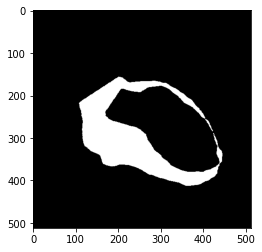

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: (512, 512, 3)
the ground truth label: Basal


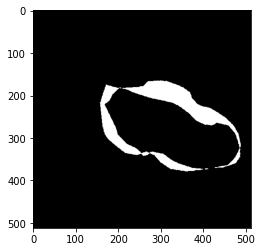

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: (512, 512, 3)
the ground truth label: Basal


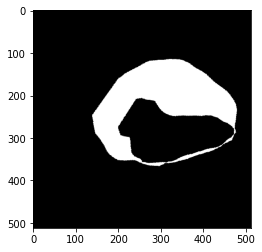

In [17]:
x,y = trn_gen.next()
for i in range(3):
    img = x[i]
    print("image shape:", img.shape)
    label = y[i]
    print("the ground truth label:", labels[label])
    plt.imshow(img)
    plt.show()

## Train the model

In [ ]:
callbacks = [
    # save_weights_only=True, 
    tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/colab_data/chimei/checkpoints/EfficientNet/efficientnetb3_4_classes_{epoch:02d}_{val_acc:.2f}.h5',
                                    save_best_only=True, monitor='val_acc', mode='max'),
]

history = model.fit(trn_gen,        
                    epochs=40, verbose=1,
                    validation_data=val_gen,
                    callbacks=callbacks,)

Epoch 1/40
26/26 [==============================] - 37s 515ms/step - loss: 1.1241 - acc: 0.4854 - val_loss: 1.3343 - val_acc: 0.3269


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
26/26 [==============================] - 12s 451ms/step - loss: 0.7128 - acc: 0.7524 - val_loss: 1.0942 - val_acc: 0.5192
Epoch 3/40
26/26 [==============================] - 12s 451ms/step - loss: 0.5100 - acc: 0.8058 - val_loss: 0.8815 - val_acc: 0.7115
Epoch 4/40
26/26 [==============================] - 12s 456ms/step - loss: 0.3272 - acc: 0.8738 - val_loss: 0.8242 - val_acc: 0.6538
Epoch 5/40
26/26 [==============================] - 11s 438ms/step - loss: 0.3619 - acc: 0.8544 - val_loss: 0.7067 - val_acc: 0.7500
Epoch 6/40
26/26 [==============================] - 12s 448ms/step - loss: 0.2725 - acc: 0.9320 - val_loss: 0.7821 - val_acc: 0.7308
Epoch 7/40
26/26 [==============================] - 11s 437ms/step - loss: 0.2304 - acc: 0.9175 - val_loss: 0.6131 - val_acc: 0.8077
Epoch 8/40
26/26 [==============================] - 12s 447ms/step - loss: 0.2398 - acc: 0.9175 - val_loss: 0.8425 - val_acc: 0.7115
Epoch 9/40
26/26 [==============================] - 11s 434ms/step - 

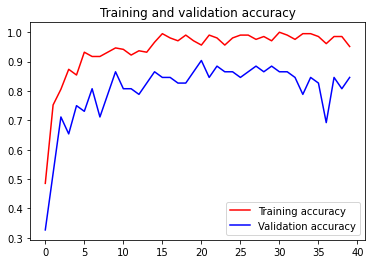

<Figure size 432x288 with 0 Axes>

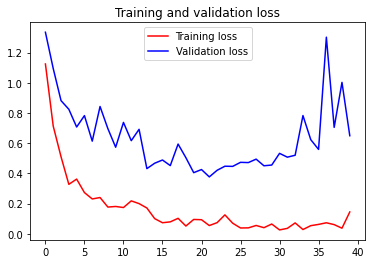

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Save / Load model

In [18]:
# model.save("drive/MyDrive/colab_data/chimei/checkpoints/EfficientNet/efficientnetb3_4_classes.h5")

model = tf.keras.models.load_model('drive/MyDrive/colab_data/chimei/checkpoints/EfficientNet/efficientnetb3_4_classes_21_0.90.h5')
# model.summary()

## Confusion matrix

In [19]:
y_true = np.array([])
y_pred = np.array([])

for step in range(26): # 52/2
  X,y = val_gen.next()
  y_true = np.append(y_true, y)
  result = model.predict(X)
  result = np.argmax(result, axis=1)
  y_pred = np.append(y_pred, result)

print(len(y_pred))
print(y_true)
print(y_pred)

52
[1. 1. 3. 0. 3. 1. 0. 0. 1. 1. 1. 0. 1. 3. 2. 3. 0. 3. 0. 1. 0. 0. 3. 0.
 1. 3. 0. 1. 0. 1. 0. 1. 0. 3. 0. 1. 3. 1. 1. 1. 1. 1. 3. 0. 0. 0. 1. 0.
 0. 2. 1. 1.]
[1. 1. 3. 0. 3. 1. 0. 0. 1. 1. 1. 0. 1. 3. 0. 3. 0. 3. 2. 0. 0. 0. 3. 0.
 1. 3. 0. 1. 0. 1. 0. 1. 0. 3. 0. 0. 3. 1. 1. 1. 1. 1. 3. 0. 0. 0. 1. 0.
 0. 2. 3. 1.]


Confusion matrix, without normalization
[[18  0  1  0]
 [ 2 18  0  1]
 [ 1  0  1  0]
 [ 0  0  0 10]]
Sensitivity/Recall for each class: [0.94736842 0.85714286 0.5        1.        ]
Sensitivity/Recall: 0.826
Specificity for each class: [0.90909091 1.         0.98       0.97619048]
Specificity: 0.966
Precision for each class: [0.85714286 1.         0.5        0.90909091]
Precision: 0.817
accuracy: 0.904


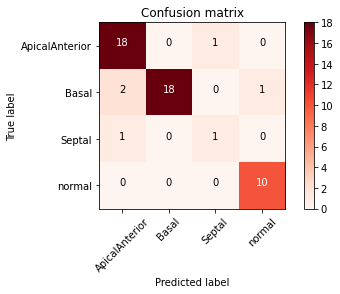

In [40]:
# get the label name list
cm_plot_labels = []
for i in range(4):
  cm_plot_labels.append(labels[i])
  # print(i, labels[i])
# get cm
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, cm_plot_labels)

# metrics
calculate_metrics(cm)
calculate_acc(cm)

## GradCAM model

In [ ]:
LAYER_NAME = 'top_activation' # top_conv,  top_activation, block7b_add, block7b_project_conv

grad_model = Model(inputs = [model.input], 
                   outputs=[model.output, model.get_layer(LAYER_NAME).output])

## Test the model

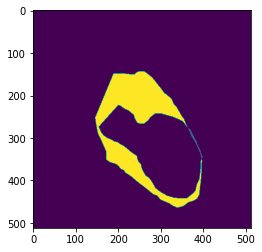

original image shape: (512, 512)
the predict result is: ApicalAnterior


In [ ]:
# ApicalAnterior
# path = "./heart_4_classes_206_52/test/ApicalAnterior/2C0336 ant hypo.png"
# path = "./heart_4_classes_206_52/test/ApicalAnterior/C3769 apical hypo.png"
# path = "./heart_4_classes_206_52/test/ApicalAnterior/C1616 (2).png" #NG

# Basal
# path = "./heart_4_classes_206_52/test/Basal/2C0034 normo.png"
# path = "./heart_4_classes_206_52/test/Basal/C3888 basal hypo.png"
# path = "./heart_4_classes_206_52/test/Basal/C2854 ant hypo.png"  #NG

# Septal
# path = "./heart_4_classes_206_52/test/Septal/C5127 apical hypo.png"
# path = "./heart_4_classes_206_52/test/Septal/C0054 apical hypo.png" #NG

# normal
# path = "./heart_4_classes_206_52/test/normal/0721_frames.png"
# path = "./heart_4_classes_206_52/test/normal/C14811 apical hypo.png"

img = mpimg.imread(path)
plt.imshow(img)
plt.show()
print("original image shape:", img.shape)
 
# predicting images
img = image.load_img(path, target_size=(512, 512))
x = image.img_to_array(img)
# print(x.shape)
x = np.expand_dims(x, axis=0)
# print(x.shape)

classes = model.predict(x)

# print(np.argmax(classes))
print("the predict result is:", labels[np.argmax(classes)])

## GradCAM result

Prediction shape: (1, 4)


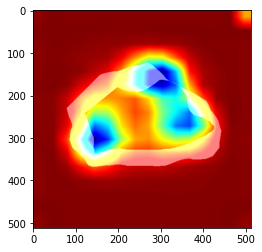

In [ ]:
# Get the score for target class
with tf.GradientTape() as tape:
    predictions, conv_outputs = grad_model(x)
    # print(predictions.shape)
    # print(conv_outputs.shape)
    loss = predictions[:, 0]
print('Prediction shape:', predictions.get_shape())
# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# Apply guided backpropagation
gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = gate_f * gate_r * grads

# Average gradients spatially
weights = tf.reduce_mean(guided_grads, axis=(0, 1))

# Build a ponderated map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, index]

# Heatmap visualization
cam = cv2.resize(cam.numpy(), (width, height))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
npimg = np.array(x[0])
output_image = cv2.addWeighted(cv2.cvtColor(npimg.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

plt.figure()
# plt.imshow(cam)
plt.imshow(output_image)
plt.show()

Reference:  
https://www.tensorflow.org/tutorials/images/transfer_learning  
https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB3  
https://github.com/tensorflow/tensorflow/issues/37680  
https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb  